# Created by Wenhan Hua
Feb 10th. 2023

In [1]:
# Load the needed package
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import cmath
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks

from scipy.integrate import solve_ivp

from tqdm import tqdm

Setting the motional constant of the e:
- $\omega_{rf} = \omega_{mm} = 10 GHz $
- $\omega_{radical} = 2 GHz $
- $\omega_{axial} = 300 MHz $
- $ d_{eff} = 200e-6 m $
- $ m = 9.10938297e-31 kg $
- $ q = 1.6e-19 $

In [2]:
# Load the parameters first 
# All in SI
wrf = 2 * np.pi* 10e9 # 10 GHz
wmm = 2 * np.pi* 10e9 # 10 GHz
wradical = 2 * np.pi * 2e9 # 2 GHz  
waxial = 2 * np.pi * 300e6 # 300 MHz
deff = 200e-6 # 200 micron
m = 9.10938297e-31 # 9.10938297e-31 kg 
q = 1.6e-19 # 1.6e-19 C

# Here are artical parameter
VoverU = 160 
r0 = 0.01 # 0.01 m

# Here are the tank circuit
Rp = 1e9
Q = 2000
#fres = 1000e7 convlution
fres = 1214e7

kB = 1.380649e-23 # Boltzman constant, given by Wikipedia
Temperature = 0.4 # Temperature for the tank circuit, given by article

# Define the spatial step size and the time step size

dt = 1e-12 # time step size
T = 640e-7 # total time
N = int(T/dt)

t_eval = np.linspace(0, T, N)

N_segment = 8
t_segment = T / N_segment

# Motion initialization

x0, y0, z0, vx0, vy0, vz0 = 0.1e-6, 0.1e-6, 0.1e-6, 0., 0., 0.
Vec0 = x0, y0, z0, vx0, vy0, vz0

# Iteration Steps
iteration_steps = 3

progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)

Simulated time (s):   0%|          | 0/6.4e-05 [00:00<?, ?it/s]

In [18]:
print(N)


64000000


DC harmonic potential:

$$V_{dc} = \kappa U (\frac{2z^2 - x^2 - y^2}{2 r_0^2})$$

RF saddle harmonic potential:

$$ V_{rf} = V \cos(\Omega_{rf} t) \frac{x^2 - y^2}{2r_0^2} $$

Pesudo potential approximation (not used in dyamics simulation):

$$ U_{ps} = \frac{1}{4m\Omega_{rf}} (F_{rf})^2 = \frac{q^2 V^2}{2m\Omega_{rf}r_0^4}(x^2 + y^2) $$

radical secular frequency is:

$$\omega_{x,y} = \frac{qV}{\sqrt{2} m\Omega_{rf}r_0^2} $$

$$\omega_z = \sqrt{\frac{q\kappa U}{mr_0^2}} $$

by [littich-thesis.pdf-Page18](./littich-thesis.pdf) 

(??? Question: it is said $\omega_u = \sqrt{a_u + q_u^2/2} \omega_{rf} /2 = \sqrt{(\frac{4qU}{mr_0^2\Omega^2}) + 2(\frac{qV}{mr_0^2\Omega^2})^2 }\omega_{rf} /2 $ , so the last equation should only holds when $ a_u << (q_u)^2 $ )


If we connect the parameter like $U, V, \kappa, r_0 $ with the intial motional parameter $\omega_r, \omega_z$, the potential parameter we chosen will make more sense:

$$ V_{dc} = \frac{1}{2} m \omega_z^2 \frac{2z^2 - x^2 - y^2}{2} $$

$$ V_{rf} = \sqrt{2}m\omega_r \Omega_{rf}\cos(\Omega_{rf} t)\frac{x^2 - y^2}{2} $$

Both $ V_{dc} $ and $ V_{rf} $ have quaratic term , we can get the expression of $ E_{dc} $ and $ E_{rf} $:

$$ \vec{E}_{dc} =\frac{1}{2q} m \omega_z^2\quad( x, y, -2z)^T $$
$$ \vec{E}_{rf} = \frac{\sqrt{2}m\omega_r \Omega_{rf}}{ q}\cos(\Omega_{rf} t) \quad (-x, y, 0)^T $$


For simplification, I choose the "Vec" for donoting "x, y, z, vx, vz, vz"

In [3]:
def Vdc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return 1/4/q * m * waxial ** 2* (2 * z ** 2 - x ** 2 - y ** 2)

def Vrf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return m * wradical * wrf * np.sqrt(2) / q * np.cos(wrf * t) * (x ** 2- y ** 2) /2

def Edc(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = 1/2/q * m * waxial ** 2
    return A * x, A * y, -2 * A * z

def Erf(Vec, t):
    x, y, z, vx, vy, vz = Vec
    A = m * wradical * wrf * np.cos(wrf * t) * np.sqrt(2) / q
    return A * (- x), A * y, 0.

# Calculate motional deviation according to Edc and Erf
def DevMotion_init(t, Vec):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t))))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m
    progress_bar.update(dt)
    return vx, vy, vz, ax, ay, az


Previously, I used Eular method for intergrating, but the total energy is not conserved, here I apply Runge-Kutta-Fehlberg Method, especially RK 45.

- RK45 intro: https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method

- Scipy for RK45: scipy.integrate.solve_ivp https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html


In [4]:
# Using RK45 to solve the ODE

solution = solve_ivp(fun=lambda t, Vec: DevMotion_init(t, Vec), 
                     t_span = (0, T), 
                     y0 = Vec0, 
                     t_eval = t_eval, 
                     first_step = 1e-13,
                     max_step = 1e-12,
                     method = 'RK45')
t_init = solution.t
VecResult_init = solution.y
x_init, y_init, z_init = VecResult_init[0, :], VecResult_init[1, :], VecResult_init[2, :]
vx_init, vy_init, vz_init = VecResult_init[3, :], VecResult_init[4, :], VecResult_init[5, :]
progress_bar.close()

# Calculate the average of the velocity in the first micromotion peroid
Tradical = 2 * np.pi / wradical
Nsec = 20 * int(Tradical // dt)
'''
vx_init_Ampl = sum(abs(vx_init[: Nsec])) / Nsec
vy_init_Ampl = sum(abs(vy_init[: Nsec])) / Nsec
vz_init_Ampl = sum(abs(vz_init[: Nsec])) / Nsec
'''
vx_init_Ampl = max(abs(vx_init[: Nsec]))
vy_init_Ampl = max(abs(vy_init[: Nsec]))
vz_init_Ampl = max(abs(vz_init[: Nsec]))

vx_Nsec = list(vx_init[: Nsec])
vy_Nsec = list(vy_init[: Nsec])
vz_Nsec = list(vz_init[: Nsec])



Simulated time (s): 100%|█████████▉| 6.399852305969895e-05/6.4e-05 [35:43<00:00, 34665211.42s/it]   /Users/mac/Library/Python/3.9/lib/python/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Simulated time (s): 600%|██████████| 0.00038400000578103614/6.4e-05 [4:04:24<-4:36:20, 38187517.55s/it]


In [19]:
f = open( 'T = 64 mus_init.txt', 'w')
for i in range(len(vx_init)):
    f.write("%.20f \t %.20f \t %.20f \t %.20f \t %.20f \t %.20f \n" % (x_init[i], y_init[i], z_init[i], vx_init[i], vy_init[i], vz_init[i]))
f.close

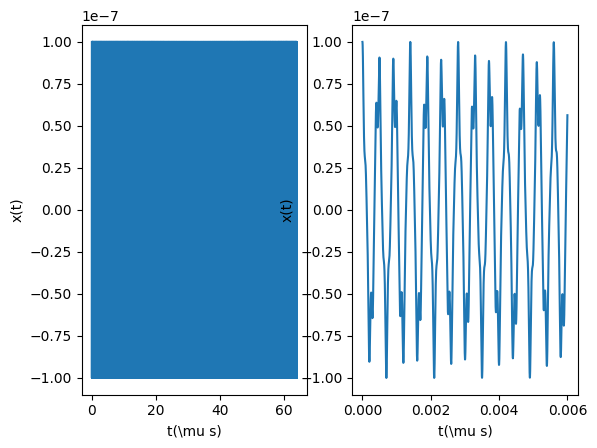

In [5]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_init*1e6, x_init)

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = int(0.6e-8/dt)
ax[1].plot(t_init[:Zoomnum]*1e6, x_init[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('x(t)')

# Show the plot
plt.show()

Get the spectrum of the motion, using ```scipy.fft.fft ```and ```scipy.fft.fftfreq```

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html

using ```scipy.signal.find_peaks``` to find peaks and make captions

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

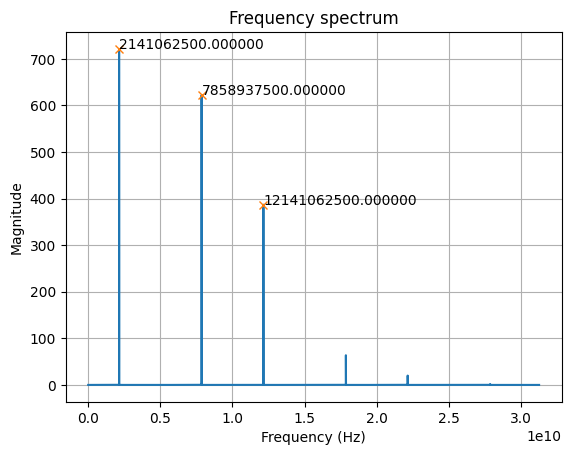

In [6]:
# Get the fourier spectrum of velocity

vxf_init = fft(vx_init)
vyf_init = fft(vy_init)
vzf_init = fft(vz_init)
tf = fftfreq(N, dt)

Front = 0
Cutoff = 16
vf = vxf_init[Front:Front + (vxf_init.size//Cutoff//2)]
ttf = tf[:N//2]
ttf = ttf[Front:Front + (ttf.size//Cutoff)]

# Get normalized magnitude of specturm
N_vf = 2.0/N * np.abs(vf[0:N//2])

if len(ttf) < len(N_vf):
    ttf = np.append(tf, [0])

# use find_peaks to get all the peaks
peaks, _ = find_peaks(N_vf, height=0)


# we only need the three largest peaks, therefore we find a border and find peaks again
temp = N_vf[peaks]
temp.sort()
temp = temp[::-1]
border = ( temp[2] + temp[3])/2

peaks, _ = find_peaks(N_vf, height= border)

#print("The location of the three largest peaks is {}, {}, {} Hz".format(tf[peaks[0]], tf[peaks[1]], tf[peaks[2]]))

# Plot the result
plt.plot(ttf, N_vf)
plt.plot(ttf[peaks], N_vf[peaks], "x")

for i in range(0,3):                                      
    plt.text(ttf[peaks[i]], N_vf[peaks[i]], "%f" % ttf[peaks[i]])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum')
plt.grid()
plt.show()

f = open( 'T = 64 mus_spectrum.txt', 'w')
for i in range(len(vx_init)):
    f.write("%.20f \t %.20f \t %.20f\n" % (vxf_init[i], vyf_init[i], vzf_init[i]))
f.close

In [7]:
print(ttf[1]- ttf[0])
print(N)

15625.0
64000000


- induced current : $I = ev/d_{eff}$
- induced voltage : $U = IR = I Re(Z) = Re(Z) ev/d_{eff}$
- induced force : $F = -e U/d = - Re(Z) \frac{e^2}{d_{eff}^2} v$

$ Re(Z)$ can have time dependence, thus acting on the electron by different pattern. In a RLC parallel circuit, the impetence $ Z $ in the frequency domin is given by:

$$ Z_{LC} = (\frac{1}{R_p} + i\omega C + \frac{1}{i\omega L})^{-1} = \frac{R_p}{[1+iQ(\frac{\omega}{\omega_R} - \frac{\omega_R}{\omega} )]} $$

Real part and imaginary part:

$$ Re(Z_{LC}) = \frac{R_p}{1 + Q^2(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})^2} $$

$$ Im(Z_{LC}) = - \frac{R_p Q(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})}{1 + Q^2(\frac{w_R + dw}{w_R}- \frac{w_R}{w_R + dw})^2} $$

where $dw$ means the detuning from $w_R$, $dw = w - w_R$

In the time domin: 

$$F(t) = -e U/d = - Re[Z](t) \frac{e^2}{d_{eff}^2} v(t)$$

According to https://www.princeton.edu/~cuff/ele201/kulkarni_text/frequency.pdf,

$$ x(t)y(t) \leftrightarrow \frac{1}{2\pi}X(\omega) * Y(\omega) = \frac{1}{2\pi} \int_{-\infty}^{+\infty} X(\eta) Y(\omega - \eta) d\eta $$



A force damping is needed for real circumstances, the damping force should be modified by a velocity factor $ \bar{v}(t)/\bar{v}(0)$, So the force should be $$F(v) = F(v_0) \times |\bar{v}(t)/\bar{v}(0)|,$$ where $F(v_0)$ means the damping force was initially calculated by only veclocity without damping force, not the real force concerning real velocity, the bar means we need to calculate the velocity amplitude average in a rf period.

In [8]:
# Calculate the damping force coefficient 
def DampingFactor(Vec, t):
    x, y, z, vx, vy, vz = Vec
    '''
    vx_Nsec.pop(0)
    vy_Nsec.pop(0)
    vz_Nsec.pop(0)
    vx_Nsec.append(vx)
    vy_Nsec.append(vy)
    vz_Nsec.append(vz)
    vx_Ampl = sum(abs(ele) for ele in vx_Nsec) / Nsec
    vy_Ampl = sum(abs(ele) for ele in vy_Nsec) / Nsec
    vz_Ampl = sum(abs(ele) for ele in vz_Nsec) / Nsec
    DampingFactor_list.append(np.sqrt(vx_Ampl ** 2 / vx_init_Ampl ** 2 + vy_Ampl ** 2 / vy_init_Ampl ** 2 + vz_Ampl ** 2 / vz_init_Ampl ** 2))
    return vx_Ampl / vx_init_Ampl, vy_Ampl / vy_init_Ampl, vz_Ampl / vz_init_Ampl
    #DampingFactor_list.append(np.sqrt(vx ** 2 / vx_init_Ampl ** 2 + vy ** 2 / vy_init_Ampl ** 2 + vz ** 2 / vz_init_Ampl ** 2))
    #return np.sqrt(vx ** 2 / vx_init_Ampl ** 2 + vy ** 2 / vy_init_Ampl ** 2 + vz ** 2 / vz_init_Ampl ** 2)
    '''
    return 1.,1.,1.

# Calculate the Damping force generated by tank circuit

def DampingForce(Vec, t):
    posi = int(t/dt) - 1
    DampingFactorx, DampingFactory, DampingFactorz = DampingFactor(Vec, t)
    # This is for damping factor method
    # return DampingFactorx * Damping_Ex[posi], 0., 0.
    # This is for time-segment method
    return DampingFactorx * Damping_Ex_temp[posi], 0., 0.


#Calculate the JN noise of the circuit
def JNNoise(Vec, t):
    posi = int(t/dt) - 1
    return JNNoise_Ex[posi], 0., 0.
    #return 0., 0., 0.

# Calculate motional deviation according to Edc and Erf
def DevMotion(t, Vec):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = tuple(map(sum, zip(Edc(Vec, t),
                                    Erf(Vec, t),
                                    DampingForce(Vec, t),
                                    JNNoise(Vec, t))))
    ax = q * Ex / m
    ay = q * Ey / m
    az = q * Ez / m
    progress_bar.update(dt)
    return vx, vy, vz, ax, ay, az


Then Johnson-Nyquist noise is added in the motional simulation, https://en.wikipedia.org/wiki/Johnson%E2%80%93Nyquist_noise

For a given bandwidth, the root mean square (RMS) of the voltage, $v_{n}$, is given by
$$v_{n}={\sqrt {\overline {v_{n}^{2}}}}{\sqrt {\Delta f}}={\sqrt {4k_{\text{B}}TR\Delta f}}$$

which means we can generate the noise distribution with a gaussion distri, where the RMS is given by $ {\sqrt {4k_{\text{B}}TR\Delta f}}$, and $\Delta f$ is given by $f_{res} / Q$ according to one of the definitions of quality factor Q, https://en.wikipedia.org/wiki/Q_factor

concerning how to add noise to a signal in Python, there is an answer says: https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

Two kinds of noise creation was recommended:
1. Markovian Noise
2. Non-Markovian Noise with correlation time $T_{corr} = 1 / \delta f_{res} = Q / f_{res}$ ; 

There is a website that supports the Non-Markovian Noise, https://www.frontiersin.org/research-topics/41181/the-role-of-non-markovian-noise-in-quantum-information-processing-tasks

(No-access)White, G. Characterization and control of non-Markovian quantum noise. Nat Rev Phys 4, 287 (2022). https://doi.org/10.1038/s42254-022-00446-2

Chang Woo Kim, et. al Analog Quantum Simulation of the Dynamics of Open Quantum Systems with Quantum Dots and Microelectronic Circuits https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.3.040308

In [9]:
# Pre-prepare for calculating the damping force(with damping pre-factor)

Rezf = Rp / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)
Imzf = Rp *  Q  * (tf / fres - fres / tf) / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2) 
#zf = complex(Rezf, Imzf)

# This is for convolution of the spectrum
#Damping_Exf = q / deff ** 2 * np.convolve(vxf_init, Rezf)

# This is for multiply of the spectrum
Damping_Exf = q / deff ** 2 * np.multiply(vxf_init, Rezf)

Damping_Ex_t = np.array(ifft(Damping_Exf))
Damping_Ex = list(Damping_Ex_t.real)
# An additional general -1 should be added, because this is damping force
Damping_Ex =[ -1 * a for a in Damping_Ex]

# Generate the JNNoise to be added into the simulation
U_rms = np.sqrt(4 * kB * Temperature * Rp * fres / Q)

# Considering Non-Markovian JN-noise, there is a correlation time -> correlation number in the list
Ncorr = int(1 / fres * Q / dt) # 1 / fres is the correlation time, so /dt brings Ncorr
#Ncorr = 1

# ? could it larger than deff?
JNNoise_Ex = 1 / deff * np.random.normal(0, U_rms, int(N/Ncorr) + 1)
JNNoise_Ey = 1 / deff * np.random.normal(0, U_rms, int(N/Ncorr) + 1)
JNNoise_Ez = 1 / deff * np.random.normal(0, U_rms, int(N/Ncorr) + 1)


JNNoise_Ex = np.repeat(JNNoise_Ex, Ncorr)[: N]
JNNoise_Ey = np.repeat(JNNoise_Ey, Ncorr)[: N]
JNNoise_Ez = np.repeat(JNNoise_Ez, Ncorr)[: N]


/var/folders/00/052dd72556d3wm86dv9755j00000gn/T/ipykernel_19076/592541140.py:3: RuntimeWarning: divide by zero encountered in divide
  Rezf = Rp / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)
/var/folders/00/052dd72556d3wm86dv9755j00000gn/T/ipykernel_19076/592541140.py:4: RuntimeWarning: divide by zero encountered in divide
  Imzf = Rp *  Q  * (tf / fres - fres / tf) / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)
/var/folders/00/052dd72556d3wm86dv9755j00000gn/T/ipykernel_19076/592541140.py:4: RuntimeWarning: invalid value encountered in divide
  Imzf = Rp *  Q  * (tf / fres - fres / tf) / (1 + Q ** 2 * (tf / fres - fres / tf) ** 2)


Simulated time (s):  75%|███████▍  | 4.799965003529527e-05/6.4e-05 [30:53<10:33, 39621096.55s/it]      /var/folders/00/052dd72556d3wm86dv9755j00000gn/T/ipykernel_19076/2334931813.py:57: RuntimeWarning: divide by zero encountered in divide
  Rezf_temp = Rp / (1 + Q ** 2 * (tf_temp / fres - fres / tf_temp) ** 2)
Simulated time (s): 600%|██████████| 0.00038400005478103595/6.4e-05 [4:07:39<-4:33:37, 38697109.69s/it]    


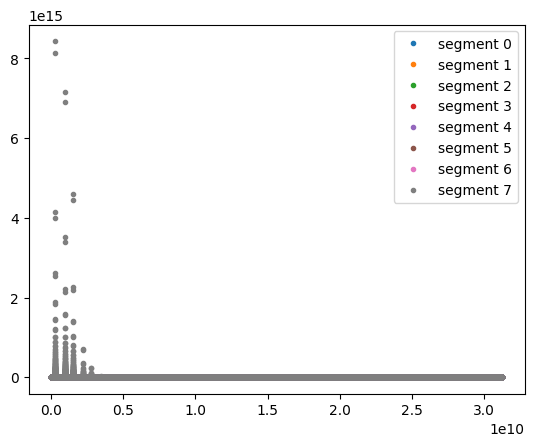

In [10]:
# Setting the process bar with tqdm
progress_bar = tqdm(total=T, desc='Simulated time (s)', position=0, leave=True)
# Using RK45 to solve the ODE
'''
solution = solve_ivp(fun=lambda t, Vec: DevMotion(t, Vec), 
                     t_span = (0, T), 
                     y0 = Vec0, 
                     t_eval = t_eval, 
                     first_step = 1e-13,
                     max_step = 1e-12,
                     method = 'RK45')

t_damp = solution.t
VecResult = solution.y
x_damp, y_damp, z_damp = VecResult[0, :], VecResult[1, :], VecResult[2, :]
vx_damp, vy_damp, vz_damp = VecResult[3, :], VecResult[4, :], VecResult[5, :]

'''
# Try time segment

Vec_temp = Vec0
x_damp = np.array([])
y_damp = np.array([])
z_damp = np.array([])
vx_damp = np.array([])
vy_damp = np.array([])
vz_damp = np.array([])

Damping_Ex_temp = Damping_Ex[: int(t_segment / dt)]

for i in range(N_segment):
    start_posi = int(i * t_segment / dt)
    end_posi = int((i + 1) * t_segment / dt)
    solution = solve_ivp(fun = lambda t, Vec: DevMotion(t, Vec),
                        t_span = (0, t_segment),
                        y0 = Vec_temp,
                        t_eval = t_eval[ : int(t_segment / dt)],
                        first_step = 1e-13,
                        max_step = 1e-12,
                        method = 'RK45')
    VecResult = solution.y
    
    x_damp_temp, y_damp_temp, z_damp_temp = VecResult[0, :], VecResult[1, :], VecResult[2, :]
    vx_damp_temp, vy_damp_temp, vz_damp_temp = VecResult[3, :], VecResult[4, :], VecResult[5, :]
    
    x_damp = np.append(x_damp, x_damp_temp[:int(t_segment / dt) - 1])
    y_damp = np.append(y_damp, y_damp_temp[:int(t_segment / dt) - 1])
    z_damp = np.append(z_damp, z_damp_temp[:int(t_segment / dt) - 1])
    vx_damp = np.append(vx_damp, vx_damp_temp[:int(t_segment / dt) - 1])
    vy_damp = np.append(vy_damp, vy_damp_temp[:int(t_segment / dt) - 1])
    vz_damp = np.append(vz_damp, vz_damp_temp[:int(t_segment / dt) - 1])
    

    Vec_temp = x_damp_temp[-1], y_damp_temp[-1], z_damp_temp[-1], vx_damp_temp[-1], vy_damp_temp[-1], vz_damp_temp[-1]
    tf_temp = fftfreq(len(vx_damp_temp), dt)

    Rezf_temp = Rp / (1 + Q ** 2 * (tf_temp / fres - fres / tf_temp) ** 2)
    vxf_temp = fft(vx_damp_temp)
    Damping_Exf_temp = q / deff ** 2 * np.multiply(vxf_temp, Rezf_temp)
    Damping_Ex_t_temp = np.array(ifft(Damping_Exf_temp))
    Damping_Ex_temp = list(Damping_Ex_t_temp.real)
    # An additional general -1 should be added, because this is damping force
    Damping_Ex_temp =[ -1 * a for a in Damping_Ex_temp]   
    
    N_tf_temp = tf[:len(vxf_temp)//2]
    N_vxf_temp = 2.0/len(vxf_temp) * np.abs(vxf_temp[0:len(vxf_temp)//2])
    plt.plot(N_tf_temp[: len(N_tf_temp) // 2], N_vxf_temp[: len(N_tf_temp) // 2], '.', label = 'segment %d' %i)

plt.legend()
progress_bar.close()

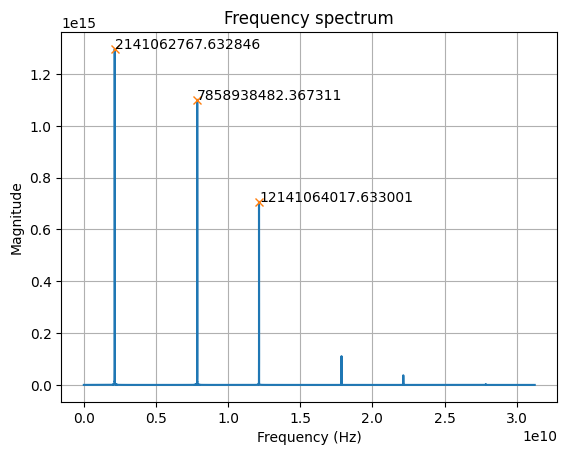

In [11]:
# Get the fourier spectrum of velocity

vxf_damp = fft(vx_damp)
vyf_damp = fft(vy_damp)
vzf_damp = fft(vz_damp)
tf = fftfreq(len(vx_damp), dt)

Front = 0
Cutoff = 16
vf = vxf_damp[Front:Front + (vxf_damp.size//Cutoff//2)]
ttf = tf[:len(vx_damp)//2]
ttf = ttf[Front:Front + (ttf.size//Cutoff)]

# Get normalized magnitude of specturm
N_vf = 2.0/N * np.abs(vf[0:N//2])

if len(ttf) < len(N_vf):
    ttf = np.append(tf, [0])

# use find_peaks to get all the peaks
peaks, _ = find_peaks(N_vf, height=0)


# we only need the three largest peaks, therefore we find a border and find peaks again
temp = N_vf[peaks]
temp.sort()
temp = temp[::-1]
border = ( temp[2] + temp[3])/2

peaks, _ = find_peaks(N_vf, height= border)

#print("The location of the three largest peaks is {}, {}, {} Hz".format(tf[peaks[0]], tf[peaks[1]], tf[peaks[2]]))

# Plot the result
plt.plot(ttf, N_vf)
plt.plot(ttf[peaks], N_vf[peaks], "x")

for i in range(0,3):                                      
    plt.text(ttf[peaks[i]], N_vf[peaks[i]], "%f" % ttf[peaks[i]])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum')
plt.grid()
plt.show()

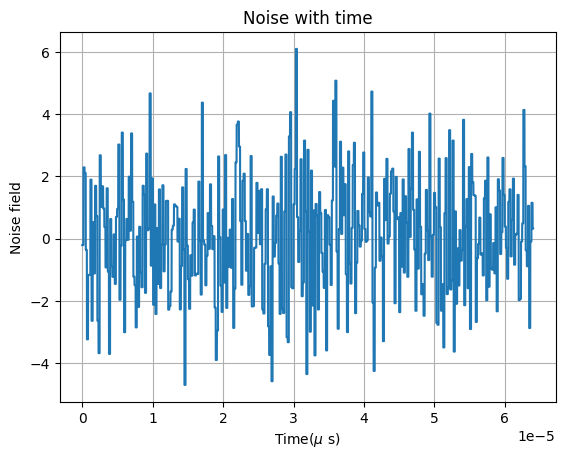

In [12]:
N_temp = range(len(JNNoise_Ex))
plt.plot(t_eval, JNNoise_Ex)
plt.xlabel('Time($\mu$ s)')
plt.ylabel('Noise field')
plt.title('Noise with time')
plt.grid()
plt.show()

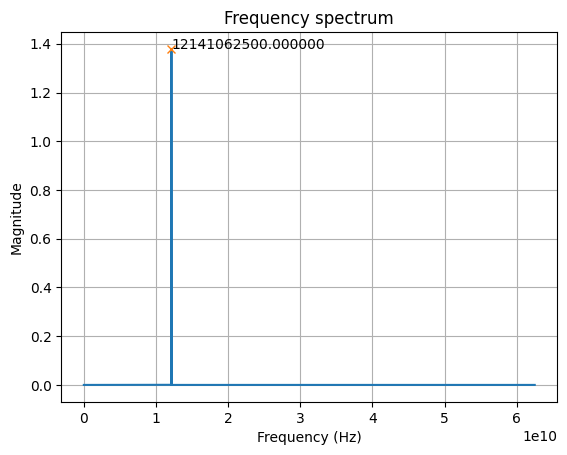

In [13]:
# Plot the E_sec t
N_Damping_Exf = 2.0/N * np.abs(Damping_Exf[0:N//2])
tf = fftfreq(N, dt)
ttf = tf[:N//2]


Front_Temp = 0
Cutoff_Temp = 8

ttf = ttf[Front_Temp:Front_Temp + (ttf.size//Cutoff_Temp)]
N_Damping_Exf = N_Damping_Exf[Front_Temp : Front_Temp +len(N_Damping_Exf)//Cutoff_Temp]

# use find_peaks to get all the peaks
peaks, _ = find_peaks(N_Damping_Exf, height=0)


# we only need the three largest peaks, therefore we find a border and find peaks again
temp = N_Damping_Exf[peaks]
temp.sort()
temp = temp[::-1]
#border = ( temp[2] + temp[3])/2
border = 1.5e-6

peaks, _ = find_peaks(N_Damping_Exf, height= border)

#print("The location of the three largest peaks is {}, {}, {} Hz".format(tf[peaks[0]], tf[peaks[1]], tf[peaks[2]]))

# Plot the result
plt.plot(ttf, N_Damping_Exf)
plt.plot(ttf[peaks], N_Damping_Exf[peaks], "x")

for i in range(0,1):                                      
    plt.text(ttf[peaks[i]], N_Damping_Exf[peaks[i]], "%f" % ttf[peaks[i]])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency spectrum')
plt.grid()
plt.show()

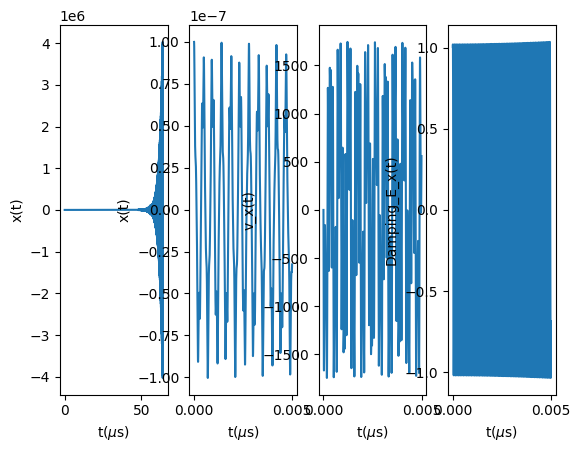

In [14]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,4)

# Plot the data on the axes
ax[0].plot(t_eval[:len(x_damp)]*1e6, x_damp)

# Add labels to the axes
ax[0].set_xlabel('t($\mu$s)')
ax[0].set_ylabel('x(t)')

Zoomnum = int(5e-9/dt)
# Plot the data on the axes
ax[1].plot(t_eval[:Zoomnum]*1e6, x_damp[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t($\mu$s)')
ax[1].set_ylabel('x(t)')

# Plot the velocity 
ax[2].plot(t_eval[:Zoomnum] * 1e6, vx_damp[: Zoomnum])

# Add labels to the axes
ax[2].set_xlabel('t($\mu$s)')
ax[2].set_ylabel('v_x(t)')

# Plot the damping force
ax[3].plot(t_eval[:Zoomnum] * 1e6, Damping_Ex[: Zoomnum])

# Add labels to the axes
ax[3].set_xlabel('t($\mu$s)')
ax[3].set_ylabel('Damping_E_x(t)')
# Show the plot
plt.show()

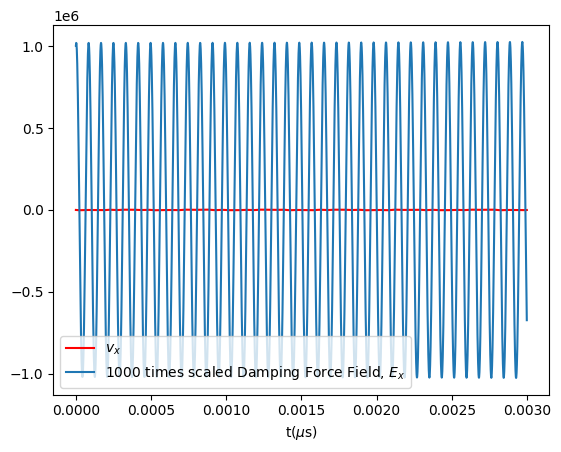

In [15]:
Zoomnum = int(30e-10/dt)
plt.plot(t_eval[:Zoomnum] * 1e6, vx_damp[: Zoomnum], 'r-', label = "$v_x$")
plt.plot(t_eval[:Zoomnum] * 1e6, 1e6 * np.array(Damping_Ex[: Zoomnum]), label = "1000 times scaled Damping Force Field, $E_x$")

plt.legend()
plt.xlabel("t($\mu$s)")
plt.show()

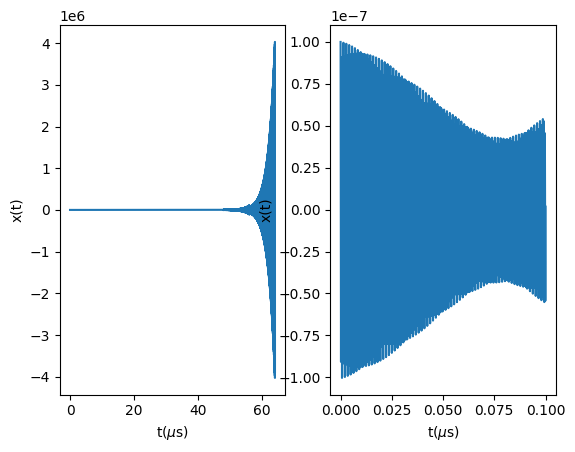

In [16]:
# Plot the x-axis motion
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_eval[:len(x_damp)]*1e6, x_damp)

# Add labels to the axes
ax[0].set_xlabel('t($\mu$s)')
ax[0].set_ylabel('x(t)')

# Plot the data on the axes
Zoomnum = int(0.1e-6/dt)
ax[1].plot(t_eval[:Zoomnum]*1e6, x_damp[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t($\mu$s)')
ax[1].set_ylabel('x(t)')

# Show the plot
plt.show()


Secular energy calculations / could also use the average energy over a period of secular motion for now

The total energy $E_{tot}$ is given by:

$$ E_{tot} = \sum_i [V_{DC}(\vec{r_i}) + V_{rf}(\vec{r_i},t) + V_{kin}(v_i) + \frac{1}{2}\sum_{j\not = i} V_{Coul} (\vec{r_i},\vec{r_j})], $$


In [17]:
'''
# Define the pesudo-potential

def Vps(Vec, t):
    x, y, z, vx, vy, vz = Vec
    Ex, Ey, Ez = Erf(Vec, t)
    return q ** 2 / 4 / m / wrf ** 2 * (Ex ** 2 + Ey ** 2 + Ez ** 2)

# Calculte for the kinetic energy

def Ekin(Vec, t):
    x, y, z, vx, vy, vz = Vec
    return 0.5 * m * (vx ** 2 + vy ** 2 + vz ** 2)

E_sec = []
for i in range(N - Nsec):
    E_sec_temp = 0
    for j in range(Nsec):
        Vec = x_damp[i + j], y_damp[i + j], z_damp[i + j], vx_damp[i + j], vy_damp[i + j], vz_damp[i + j]
        E_sec_temp = E_sec_temp + Vdc(Vec, t_eval[i + j]) + Vrf(Vec, t_eval[i + j]) + Ekin(Vec, t_eval[i + j])
    E_sec.append(E_sec_temp / Nsec)

# plot the secular energy
fig1, ax = plt.subplots(1,2)

# Plot the data on the axes
ax[0].plot(t_eval[: N - Nsec]*1e6, E_sec[: N - Nsec])

# Add labels to the axes
ax[0].set_xlabel('t(\mu s)')
ax[0].set_ylabel('E(t)')

# Plot the data on the axes
Zoomnum = int(0.6e-8/dt)
ax[1].plot(t_eval[:Zoomnum]*1e6, E_sec[:Zoomnum])

# Add labels to the axes
ax[1].set_xlabel('t(\mu s)')
ax[1].set_ylabel('E(t)')

# Show the plot
plt.show()

'''

"\n# Define the pesudo-potential\n\ndef Vps(Vec, t):\n    x, y, z, vx, vy, vz = Vec\n    Ex, Ey, Ez = Erf(Vec, t)\n    return q ** 2 / 4 / m / wrf ** 2 * (Ex ** 2 + Ey ** 2 + Ez ** 2)\n\n# Calculte for the kinetic energy\n\ndef Ekin(Vec, t):\n    x, y, z, vx, vy, vz = Vec\n    return 0.5 * m * (vx ** 2 + vy ** 2 + vz ** 2)\n\nE_sec = []\nfor i in range(N - Nsec):\n    E_sec_temp = 0\n    for j in range(Nsec):\n        Vec = x_damp[i + j], y_damp[i + j], z_damp[i + j], vx_damp[i + j], vy_damp[i + j], vz_damp[i + j]\n        E_sec_temp = E_sec_temp + Vdc(Vec, t_eval[i + j]) + Vrf(Vec, t_eval[i + j]) + Ekin(Vec, t_eval[i + j])\n    E_sec.append(E_sec_temp / Nsec)\n\n# plot the secular energy\nfig1, ax = plt.subplots(1,2)\n\n# Plot the data on the axes\nax[0].plot(t_eval[: N - Nsec]*1e6, E_sec[: N - Nsec])\n\n# Add labels to the axes\nax[0].set_xlabel('t(\\mu s)')\nax[0].set_ylabel('E(t)')\n\n# Plot the data on the axes\nZoomnum = int(0.6e-8/dt)\nax[1].plot(t_eval[:Zoomnum]*1e6, E_sec[:Zoo